In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

Reference (ie made by Jeremy Howard and copied from here): https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline

## Introduction

This kernel shows how to use NBSVM (Naive Bayes - Support Vector Machine) to create a strong baseline (originally for the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) competition). NBSVM was introduced by Sida Wang and Chris Manning in the paper [Baselines and Bigrams: Simple, Good Sentiment and Topic Classiﬁcation](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf). In this kernel, we use sklearn's logistic regression, rather than SVM, although in practice the two are nearly identical (sklearn uses the liblinear library behind the scenes).

If you're not familiar with naive bayes and bag of words matrices, [Jeremy Howard] made a preview available of one of fast.ai's upcoming *Practical Machine Learning* course videos, which introduces this topic. Here is a link to the section of the video which discusses this: [Naive Bayes video](https://youtu.be/37sFIak42Sc?t=3745).

In [60]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import emoji
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
)
import matplotlib.pyplot as plt
import text_utils

<IPython.core.display.Javascript object>

In [5]:
# balanced data set?
df["harmful_type"].value_counts(normalize=True)

0     0.572729
7     0.285155
8     0.074401
12    0.029661
2     0.013230
3     0.008109
9     0.007042
6     0.004161
1     0.002169
4     0.001423
11    0.001280
5     0.000427
10    0.000213
Name: harmful_type, dtype: float64

<IPython.core.display.Javascript object>

In [6]:
# filter it to observe
df[df.isna().any(axis=1)].head(12)

,comment,language,translation,harmful,harmful_type
759,https://www.youtube.com/channel/UCvFSvEpuZGX-s...,en,NaN,1,12
1096,https://www.youtube.com/channel/UCfzr7vTFpwPLf...,en,NaN,1,12
1297,https://vk.com/wall-161882422_144,en,NaN,1,12
2334,https://www.youtube.com/channel/UCvOp175eicZuz...,en,NaN,1,12
2617,https://uk.trustpilot.com/review/store.com,en,NaN,1,7
3020,https://www.instagram.com/p/BoR1OA0FeqM/?utm_s...,en,NaN,1,12
3752,https://rr.lovevova.com/NzY5NjEyOQ==,en,NaN,1,12
4314,https://www.store.com/fr,en,NaN,1,12
4816,https://www.nw.de/lokal/bielefeld/mitte/219875...,en,NaN,1,8
5035,https://www.facebook.com/pg/patilerim2018/posts/,en,NaN,1,12


<IPython.core.display.Javascript object>

In [7]:
# drop missing values
df = df.dropna(how="any")

<IPython.core.display.Javascript object>

In [8]:
comments_df = df.loc[:, ["translation", "harmful"]]
comments_df["translation"] = [emoji.demojize(x) for x in comments_df["translation"]]

<IPython.core.display.Javascript object>

In [9]:
comments_df.head()

,translation,harmful
0,"Oh, there was such a country, and you have to ...",1
1,Hahahaha for that I buy them the top blanket,0
2,This is a fake one,1
3,Use me as a dislike button,1
4,Can I order?,0


<IPython.core.display.Javascript object>

In [12]:
# clean comments
comments_df["comment_text"] = comments_df["translation"].apply(
    lambda x: text_utils.clean_text(x)
)

<IPython.core.display.Javascript object>

In [13]:
comments_df.head(2)

,translation,harmful,comment_text
0,"Oh, there was such a country, and you have to ...",1,oh country overpay
1,Hahahaha for that I buy them the top blanket,0,hahahaha buy top blanket


<IPython.core.display.Javascript object>

## splitting datasets

In [14]:
import pickle

# with open("comments_df.pickle", "wb") as f:
#     pickle.dump(comments_df, f)

# comments_df = pickle.load(open("comments_df.pickle", "rb"))

<IPython.core.display.Javascript object>

In [15]:
# feature selection
label = "harmful"
ignore_cols = [label, "translation_clean"]
features = [c for c in comments_df.columns if c not in ignore_cols]

# split the data into train and test
train, test, y_train, y_test = train_test_split(
    comments_df[features], comments_df[label], test_size=0.20, random_state=42
)

<IPython.core.display.Javascript object>

In [16]:
train_label_dummies = pd.get_dummies(y_train)
test_label_dummies = pd.get_dummies(y_test)

<IPython.core.display.Javascript object>

In [17]:
train_label_dummies.head()

,0,1
25338,1,0
19449,1,0
2586,1,0
27052,1,0
15215,0,1


<IPython.core.display.Javascript object>

In [18]:
test_label_dummies.head()

,0,1
20046,1,0
5686,0,1
11483,0,1
27186,1,0
428,1,0


<IPython.core.display.Javascript object>

In [19]:
train = pd.concat([train, train_label_dummies], axis=1, sort=False)

<IPython.core.display.Javascript object>

## Looking at the data

In [20]:
train.head()

,translation,comment_text,0,1
25338,:red_heart:,red_heart,1,0
19449,How orders are placed,order place,1,0
2586,Thank you for the info. Have a nice day.,thank info nice day,1,0
27052,The first case on Honor 10?,first case honor,1,0
15215,All of quality 0,quality,0,1


<IPython.core.display.Javascript object>

The length of the comments may vary.

In [22]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(32.48570792520036, 79.34430250894692, 4513)

<IPython.core.display.Javascript object>

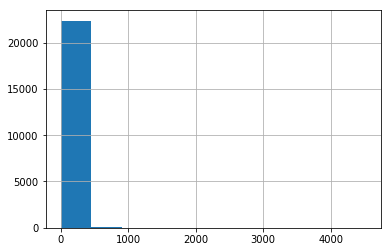

<IPython.core.display.Javascript object>

In [23]:
lens.hist()

In [29]:
len(train), len(test)

(22460, 5616)

<IPython.core.display.Javascript object>

If there are a few empty comments, we need to get rid of it, otherwise sklearn will complain.

In [30]:
COMMENT = "comment_text"
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

<IPython.core.display.Javascript object>

## Building the model

We'll start by creating a *bag of words* representation, as a *term document matrix*. We'll use ngrams, as suggested in the NBSVM paper.

In [31]:
import re, string

re_tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")


def tokenize(s):
    return re_tok.sub(r" \1 ", s).split()

<IPython.core.display.Javascript object>

It turns out that using TF-IDF gives even better priors than the binarized features used in the paper. I don't think this has been mentioned in any paper before [but, originally, it improved leaderboard score from 0.59 to 0.55].

In [33]:
n = train.shape[0]
vec = TfidfVectorizer(
    ngram_range=(1, 2),
    tokenizer=tokenize,
    min_df=3,
    max_df=0.9,
    strip_accents="unicode",
    use_idf=1,
    smooth_idf=1,
    sublinear_tf=1,
)
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

<IPython.core.display.Javascript object>

This creates a *sparse matrix* with only a small number of non-zero elements (*stored elements* in the representation  below).

In [34]:
trn_term_doc, test_term_doc

(<22460x6958 sparse matrix of type '<class 'numpy.float64'>'
 	with 148995 stored elements in Compressed Sparse Row format>,
 <5616x6958 sparse matrix of type '<class 'numpy.float64'>'
 	with 34741 stored elements in Compressed Sparse Row format>)

<IPython.core.display.Javascript object>

Here's the basic naive bayes feature equation:

In [35]:
def pr(y_i, y):
    p = x[y == y_i].sum(0)
    return (p + 1) / ((y == y_i).sum() + 1)

<IPython.core.display.Javascript object>

In [36]:
x = trn_term_doc
test_x = test_term_doc

<IPython.core.display.Javascript object>

Fit a model for one dependent at a time:

In [37]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1, y) / pr(0, y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

<IPython.core.display.Javascript object>

In [38]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print("fit", j)
    m, r = get_mdl(train[j])
    preds[:, i] = m.predict_proba(test_x.multiply(r))[:, 1]

fit 0


C:\Users\daniel.andrade\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


fit 1


<IPython.core.display.Javascript object>

## results

In [39]:
preds[:4]

array([[0.98789355, 0.01210645],
       [0.14578665, 0.85421334],
       [0.68610741, 0.31389253],
       [0.88052083, 0.1194791 ]])

<IPython.core.display.Javascript object>

In [40]:
preds_class = np.argmax(preds, axis=1)

<IPython.core.display.Javascript object>

In [43]:
print("Accuracy:", accuracy_score(y_test.values, preds_class))
print("F1-score:", f1_score(y_test.values, preds_class, average="macro"))
print("Precision:", precision_score(y_test.values, preds_class, average="macro"))
print("Recall:", recall_score(y_test.values, preds_class, average="macro"))

Accuracy: 0.8076923076923077
F1-score: 0.799336600703894
Precision: 0.8111367471294026
Recall: 0.7947130222275298


<IPython.core.display.Javascript object>

Normalized confusion matrix


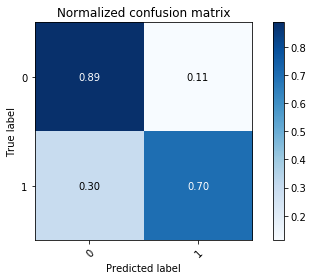

<IPython.core.display.Javascript object>

In [48]:
text_utils.plot_confusion_matrix(
    y_test.values,
    preds_class,
    normalize=True,
    classes=[0, 1],
    title="Normalized confusion matrix",
)
plt.show()

In [49]:
def print_report(y_test, y_pred):

    report = classification_report(y_test, y_pred)
    print(report)
    print("accuracy: {:0.3f}".format(accuracy_score(y_test, y_pred)))


print_report(y_test.values, preds_class)

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      3203
           1       0.82      0.70      0.76      2413

   micro avg       0.81      0.81      0.81      5616
   macro avg       0.81      0.79      0.80      5616
weighted avg       0.81      0.81      0.81      5616

accuracy: 0.808


<IPython.core.display.Javascript object>

In [52]:
print("ROC AUC score:", roc_auc_score(y_test.values, preds_class))

ROC AUC score: 0.7947130222275299


<IPython.core.display.Javascript object>